# Approximate matrix multiplication using a randomized sketch

In the companion notebook, I show a way to sketch vectors $x$ and $y$ with random
scalars $\hat{x}$ and $\hat{y}$ so that the product $\hat{x} \hat{y}$  has
expected value $x^Ty$.  In this notebook, I use this sketch to approximate
matrix multiplication.  I generate a matrix $M$ and a vector $v$. Then I sketch
$v$ and each row $r$ of $M$.

For each row $r$ of $M$,  denoted by $M_r$, I select an entry $c$ at random with
probability proptional to the magnitude of each entry. This makes $M_{rc}$ a random variable since $c$ is random. It's easy to show (see the companion notebook) that the expected value of $v_c \cdot \text{sgn}\left(M_{r c}\right) \cdot \sum_{c'} \left|M_{rc'}\right|$ is $M_r^\top v$. The right hand side of this equation is the $r$th entry of the matrix-vector product $Mv$. We repeat this process for each $r$ to get an unbiased estimate of the vector $Mv$. We'll repeat this a few times and average the resulting vector to get a low-variance estimate of $Mv$.

All of this can be done extremely efficiently using `scatter_add`, as is done in the implementation.  Another way to view this scheme is that it converts a dense matrix $M$ into a random sparse matrix $M_+$ whose nonzero entries are +1, a random sparse matrix $M_-$ whose nonzero entries are -1, and deterministc diagonal matrix $D$ whose $rr$ th entry is $\frac{1}{\text{num\_sketches}} \sum_{c} \left|M_{rc}\right|$. This decomposition is such that the expected value of  $D \left(M_+ + M_-\right)$ is $M$. But because $M_+$ and $M_-$ are sparse and binary, multiplying a vector $v$ by $D \left(M_+ + M_-\right)$ is much faster than multiplying by $M$.

Text(0, 0.5, 'Relative error')

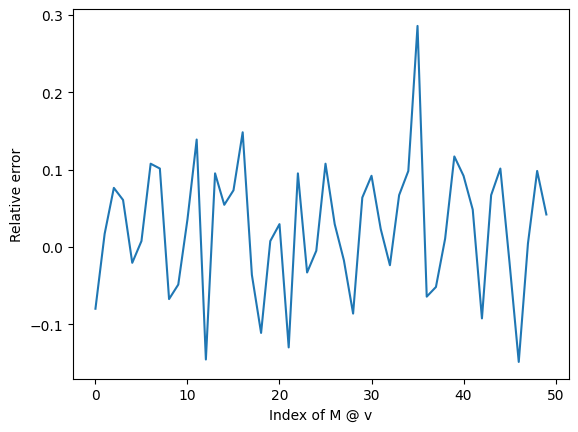

In [168]:
from importlib import reload
import matplotlib.pyplot as plt
import torch

import matrix_product_sketch

reload(matrix_product_sketch)

num_rows = 50
num_cols = 64

# Generate an arbitrary matrix.
M = torch.arange(num_rows * num_cols, dtype=float).reshape((num_rows, num_cols))
M -= M.mean(axis=1)[:, None]

# Generate an arbitrary vector.
vec = torch.linspace(-10.0, 10.0, num_cols, dtype=float)

# Compare the dot product Mx against the sketched dot product.
mv = M @ vec

# Sketch the rows of M using 10 randomly selected entries from each row. Then
# apply this sketch to vec.
M_est = matrix_product_sketch.MatrixProductSketch(M, num_sketches=15)
mv_est = M_est @ vec

plt.plot(1 - mv_est / mv)
plt.xlabel("Index of M @ v")
plt.ylabel("Relative error")